In [51]:
import pandas as pd
import torch
import os
import sklearn
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import sys
from tqdm import tqdm
sys.path.append('./..')
sys.path.append('./../..')
from pandarallel import pandarallel
pandarallel.initialize()
import glob 
import yaml
import pickle
from scipy.special import softmax as SOFTMAX
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from common_utils import utils
try:
    from common_utils import AD_result_fetcher
except:
    from .common_utils import AD_result_fetcher
from sklearn.metrics.pairwise import pairwise_distances_argmin
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from torch import nn
from torch.nn import functional as F
from torch import LongTensor as LT
from torch import FloatTensor as FT

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
def obtain_bipartite_embeddings():
    global DIR
    LOC = './saved_model_data'
    _files = sorted(glob.glob(os.path.join(LOC,DIR, '**.npy')))
    emb_dict = {}
    for file in _files:
        _domain = file.split('/')[-1].split('_')[0]
        emb_dict[_domain] = np.load(file)
    return emb_dict



In [6]:
# ---------------------------------------------
# Convert the df from serial_ID to entity_ID
# ---------------------------------------------
def convert_toEntityID(target_df):
    global bipartite_domains
    serialID_map_df = utils.fetch_idMappingFile(DIR)
    serialID_entityID_dict = {}
    
    for domain in set(bipartite_domains):
        if domain not in target_df.columns : continue
        tmp =  serialID_map_df.loc[(serialID_map_df['domain'] == domain)]
        serial_id = tmp['serial_id'].values.tolist()
        entity_id = tmp['entity_id'].values.tolist()
        serialID_entityID_dict[domain] = {k:v for k,v in zip(serial_id,entity_id)}
   
    def convert_aux(val, domain):
        return serialID_entityID_dict[domain][val]
    domain_list = bipartite_domains
    for domain in tqdm(domain_list):
        target_df[domain] = target_df[domain].parallel_apply(convert_aux, args=(domain,))
    return target_df



In [12]:
# -----------------------------
# Create synthetic mapping 
# So that ids are continuous. 
# Also embeddings can be accessed using an numpy array
# -----------------------------  
def convert_to_SynID (data_df, emb_dict):
    global bipartite_domains
    global DATA_LOC
    global DIR
    
    with open(os.path.join(DATA_LOC, DIR, 'domain_dims.pkl'),'rb') as fh:
        domain_dims = pickle.load(fh)
        
    synID = 0
    cur = 0
    col_syn_id = []
    col_entity_id = []
    col_domain_names = []
    
    # ------------------
    for d in sorted(bipartite_domains):
        s = domain_dims[d]
        col_entity_id.extend(list(range(s)))
        col_domain_names.extend([d for _ in range(s)])
        tmp = np.arange(s) + cur
        tmp = tmp.tolist()
        col_syn_id.extend(tmp)
        cur += s

    data = {'domain': col_domain_names, 'entity_id': col_entity_id, 'syn_id': col_syn_id}
    synID_mapping_df = pd.DataFrame(data)

    # -------------------
    # Replace entity_id with synthetic id 
    # -------------------
    mapping_dict = {}
    for domain in sorted(set(synID_mapping_df['domain'])):
        tmp =  synID_mapping_df.loc[(synID_mapping_df['domain'] == domain)]
        syn_id = tmp['syn_id'].values.tolist()
        entity_id = tmp['entity_id'].values.tolist()
        mapping_dict[domain] = { k:v for k,v in zip(entity_id,syn_id) }
        def convert_aux(val, domain):
            return mapping_dict[domain][val]

    for domain in tqdm(bipartite_domains):
        data_df[domain] = data_df[domain].parallel_apply(convert_aux, args=(domain,))
    
    num_entities = len(synID_mapping_df)
    emb_array = np.zeros( [num_entities, emb_dict[bipartite_domains[0]].shape[-1]])
    
    for dom in bipartite_domains:
        tmp = synID_mapping_df.loc[synID_mapping_df['domain']==dom]
        synID = tmp['syn_id'].values
        entityID = tmp['entity_id'].values
        emb_array[synID] = emb_dict[dom][entityID]
        
    return data_df,  emb_array , synID_mapping_df

In [38]:
config_file = 'config.yaml'
with open(config_file,'r') as fh:
    CONFIG = yaml.safe_load(fh)

In [39]:
    
attr_consignee = CONFIG['attribute_SHIPPER']
attr_shipper = CONFIG['attribute_CONSIGNEE']
ID_COL = CONFIG['ID_COL']
DATA_LOC = CONFIG['DATA_LOC']
bipartite_domains = sorted([attr_consignee, attr_shipper])
NEG_PERCENTILE_THRESHOLD = CONFIG['NEG_PERCENTILE_THRESHOLD']

In [28]:
DIR = 'us_import1'

labelled_results = AD_result_fetcher.read_in_AD_result(DIR)
ANOMALY_PERCENTILE_THRESHOLD  = CONFIG['ANOMALY_PERCENTILE_THRESHOLD']
score_threshold = np.percentile(labelled_results['score'],CONFIG['ANOMALY_PERCENTILE_THRESHOLD'])
print(CONFIG['ANOMALY_PERCENTILE_THRESHOLD'], score_threshold)
bipartite_embeddings = obtain_bipartite_embeddings()

main_df = (labelled_results[[ID_COL , 'label', 'score'] + bipartite_domains]).copy()
df1 = convert_toEntityID(main_df.copy())
data_df, emb_array , synID_mapping_df = convert_to_SynID (df1.copy(), bipartite_embeddings)

  0%|          | 0/2 [00:00<?, ?it/s]

22648 22648
95 0.5650949312585849


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


In [29]:
working_df = data_df.copy()
working_df['dynamic_score'] = working_df['score'].values
# ------------------
# Type conversion : to ensure no bugs
# ------------------
working_df['PanjivaRecordID'] = working_df['PanjivaRecordID'].astype(int)
working_df['ConsigneePanjivaID'] = working_df['ConsigneePanjivaID'].astype(int)
working_df['ShipperPanjivaID'] = working_df['ShipperPanjivaID'].astype(int)
working_df = working_df.reset_index(drop=True)

In [126]:
class mlp_clf(nn.Module):
    def __init__(self, emb):
        super(mlp_clf, self).__init__()
        print(emb)
        emb_dim = emb.shape[-1]
        self.embedding = nn.Embedding.from_pretrained(FT(emb))
        self.fc = nn.Sequential(
            self.embedding,
            nn.Linear(emb_dim, emb_dim//2),
            nn.Dropout(0.1),
            nn.Tanh(),
            nn.Linear(emb_dim//2, emb_dim//4),
            nn.Dropout(0.1),
            nn.Tanh(),
            nn.Linear(emb_dim//4,1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        return self.fc(x)
    

In [167]:
class mlp_container():
    def __init__(self,emb):
        self.clf_obj = mlp_clf(emb) 
    
    def train(
        self, 
        x_pos, 
        x_neg,
        batch_size = 64,
        epochs = 10000,
        log_interval = 200
    ):
        
        self.clf_obj.train()
        x_pos = np.array(list(x_pos)).reshape([-1,1])
        x_neg = np.array(list(x_neg)).reshape([-1,1])
        opt = torch.optim.Adam(list(self.clf_obj.parameters()))
        for e in range(epochs):
            opt.zero_grad()
            idx_p = np.random.choice(np.arange(x_pos.shape[0]),batch_size,replace=True)
            _x_p = x_pos[idx_p]
            y_p = np.ones(_x_p.shape[0])
            
            idx_n = np.random.choice(np.arange(x_neg.shape[0]),batch_size,replace=True)
            _x_n = x_neg[idx_n]
            
            y_n = np.zeros(_x_n.shape[0])
            _y = FT(np.vstack([y_p,y_n]))
            _x = LT(np.vstack([_x_p,_x_n]))
            pred = self.clf_obj(_x)
            
            _loss = F.binary_cross_entropy(pred,_y,reduction='none')
            _loss = torch.mean(_loss)
            _loss.backward()
            opt.step()
            
            if e%log_interval == 0 :
                print('Epoch {} Loss {}'.format(e, np.mean(_loss.cpu().data.numpy())))
        self.clf_obj.eval()
    
    def score(self, x):
        
        self.clf_obj.eval()
        return self.clf_obj(LT(x)).cpu().data.numpy()
            
     

In [197]:
def process(df_cur, emb_array, label_top_k = 5,  mlp = None,) :   
    global ID_COL
    global attr_consignee
    global attr_shipper
    global ANOMALY_PERCENTILE_THRESHOLD
    global NEG_PERCENTILE_THRESHOLD
    global bipartite_domains
    df_cur = df_cur.sort_values(by='score',ascending=False)
    min_score = np.percentile(df_cur['score'], ANOMALY_PERCENTILE_THRESHOLD)

    seen_ids = []
    count = 0
    labelled_df = None
    idx = 0

    for i,row in df_cur.iterrows():
        _id = int(row[ID_COL])
        idx = i
        seen_ids.append(_id)

        if row['label']==1: 
            count +=1
            if count > label_top_k : 
                break
        
    seen_ids = set(seen_ids)
    labelled_df = df_cur.iloc[:idx,:]
    unlabelled_df = df_cur.iloc[idx:,:]
    orig_target_df = unlabelled_df.copy().reset_index(drop=True)
    
    print('# of records revealed to find {} instances at the top :: {}'.format(
        label_top_k, 
        len(labelled_df))
    )
    labelled_df_n = labelled_df.loc[labelled_df['label']==-1]
    labelled_df_p = labelled_df.loc[labelled_df['label']==1]
    
    # ------------------------------------------------
    # Assume labels to be 0 for entities in records in lower 50 percentile
    # ------------------------------------------------
    neg_label_cutoff_score = np.percentile(df_cur['score'], NEG_PERCENTILE_THRESHOLD)

    tmp = unlabelled_df.loc[unlabelled_df['score'] < neg_label_cutoff_score]
    neg_label_entities = []
    
    for domain in bipartite_domains:
        neg_label_entities.extend(tmp[domain].values.tolist())
        neg_label_entities.extend(labelled_df_n[domain].values.tolist())
        
    neg_label_entities = set(neg_label_entities)
    
    pos_label_entities = []
    for domain in bipartite_domains: 
        pos_label_entities.extend(labelled_df_n[domain].values.tolist())
    
    pos_label_entities = set(pos_label_entities)
    
    neg_label_entities = neg_label_entities.difference(pos_label_entities)
    print(len(pos_label_entities), len(neg_label_entities))
    
    pos_label_entities = list(set(pos_label_entities))
    neg_label_entities = list(set(neg_label_entities))
    # ---------------------------------
    # Build a classifier 
    # ---------------------------------
    if mlp is None:
        mlp = mlp_container(emb_array)
        mlp.train(
            pos_label_entities,
            neg_label_entities
        )
    print(pos_label_entities[0])
    # ---------------------------------
    # score entities 
    num_entities = emb_array.shape[0]
    clf_scores = mlp.score(np.arange(num_entities))
    print(clf_scores.shape)
    
    # ------------------------------
    # Now for records with score higher than threshold 
    # Calculate a new score for each record 
    # ------------------------------
    candidates = unlabelled_df.loc[unlabelled_df['score']>=min_score ]
    
    def aux_score(row):
        s = 0
        if int(row[attr_consignee]) in pos_label_entities:
            s +=1
        else:
            s += clf_scores[int(row[attr_consignee])]
        
        if int(row[attr_shipper]) in pos_label_entities: 
            s +=1
        else:
            s += clf_scores[int(row[attr_shipper])]
        s = s/2
        s = row['score'] + s
        return s
            
    # first see records where both match
    df1 = candidates.loc[candidates[attr_consignee].isin(pos_label_entities) & (candidates[attr_shipper].isin(pos_label_entities))]
    df1['dynamic_score'] = 2
    df2 = candidates.loc[~candidates[ID_COL].isin(df1[ID_COL])]
    df2['dynamic_score'] = df2.parallel_apply(aux_score,axis=1)
    
    new_df = df1.append(df2,ignore_index=True)
    new_df = new_df.sort_values( by = 'dynamic_score', ascending=False)
    
    for k in [50,100,150,200,250]:
        # without input?
        top_k_target = orig_target_df.head(k)
        wo_input_precison = len(top_k_target.loc[top_k_target['label']==1])/k
        tmp =  new_df.head(k)
        correct = tmp.loc[tmp['label']==1]
        prec = len(correct)/len(tmp)
        print(' precision at next top {:3d} : {:.3f}'.format(k, prec), ' || Without input {:.3f}'.format(wo_input_precison) )

    return mlp
    
    
  

In [195]:
emb_array.shape

(10012, 32)

In [198]:
mlp = process(working_df.copy(),emb_array, 5, mlp)     

# of records revealed to find 5 instances at the top :: 11
12 4061
2048
(10012, 1)


/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 precision at next top  50 : 0.020  || Without input 0.460
 precision at next top 100 : 0.210  || Without input 0.410
 precision at next top 150 : 0.347  || Without input 0.433
 precision at next top 200 : 0.355  || Without input 0.460
 precision at next top 250 : 0.324  || Without input 0.488


/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [199]:
num_entities = emb_array.shape[1]
scores = mlp.score(np.arange(num_entities))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f15e4548fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f15e44fe210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f15e45488d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f15e44fe110>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f15e4520090>],
 'means': []}

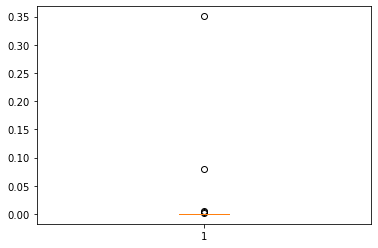

In [201]:
import matplotlib.pyplot as plt
plt.boxplot(scores)

In [37]:
process(working_df.copy(),10)  
process(working_df.copy(),20)  
process(working_df.copy(),30)   
process(working_df.copy(),40)   
process(working_df.copy(),50)   

# of records revealed to find 5 instances at the top :: 11
# of records revealed to find 10 instances at the top :: 24
# of records revealed to find 20 instances at the top :: 44
# of records revealed to find 30 instances at the top :: 73
# of records revealed to find 40 instances at the top :: 105
# of records revealed to find 50 instances at the top :: 123
